In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image
from io import BytesIO

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from ViT_model.vit_model import vit_base_patch16_224 as ViT_model

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
%matplotlib inline

In [2]:
#  参数设定
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#  超参设定
BATCH_SIZE = 128
BATCH_SIZE_LOW = 48
LEARNING_RATE = 0.00001
NUM_EPOCHS = 60
RANDOM_SEED = 1
NUM_FEATURES = 784

NUM_CLASSES = 3
GRAYSCALE = False

In [65]:
#  混淆矩阵函数
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def draw_confusion_matrix(loader, model, labels, num_classes, device):
    
    conf_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for idx, (features, targets) in enumerate(loader):

            targets = targets.squeeze()
            targets = targets.to(device)
            features = features.to(device)

            if (model == model_vit_low) or (model == model_vit_high):
                pred = model(features)
            else:
                _, pred = model(features)

            conf_matrix = confusion_matrix(pred, targets, conf_matrix)
            conf_matrix = conf_matrix.cpu()
            
    conf_matrix=np.array(conf_matrix.cpu())# 将混淆矩阵从gpu转到cpu再转到np
    corrects=conf_matrix.diagonal(offset=0)#抽取对角线的每种分类的识别正确个数
    per_kinds=conf_matrix.sum(axis=1)#抽取每个分类数据总的测试条数

    print("混淆矩阵总元素个数：{0},测试集总个数:{1}".format(int(np.sum(conf_matrix)),int(np.sum(conf_matrix))))
    print(conf_matrix)
    
    plt.imshow(conf_matrix, cmap = plt.cm.Blues)

    thresh = conf_matrix.max() / 2
    for x in range(num_classes):
        for y in range(num_classes):
            info = int(conf_matrix[y, x])
            plt.text(x, y, info,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color="white" if info > thresh else "black")

    plt.tight_layout()
    plt.yticks(range(num_classes), labels)
    plt.xticks(range(num_classes), labels,rotation=45)
    plt.show()
    plt.close()

In [6]:
#  创建两类数据集 -> 白人、黑人、其他人种

class RaceDatasetsHigh(Dataset):
    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.img_names = [i for i in os.listdir(img_dir) if i.endswith('.png')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[1] == 'white':
                self.y.append(0)
            elif i.split('.')[1] == 'black':
                self.y.append(1)
            elif i.split('.')[1] == 'asian':
                self.y.append(2)
            elif i.split('.')[1] == 'hispanic':
                self.y.append(2)
            elif i.split('.')[1] == 'other':
                self.y.append(2)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        return img, label
    
custom_transform1 = transforms.Compose([transforms.Resize([128, 128]),
                                       transforms.ToTensor()])

train_high_dataset = RaceDatasetsHigh(img_dir = os.path.join('facedata', 'train'),
                            transform=custom_transform1)

train_high_loader = DataLoader(dataset = train_high_dataset,
                        batch_size = 256,
                        shuffle = False)

train_high_mean = []
train_high_std = []


for i, image in enumerate(train_high_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_high_mean.append(batch_mean)
    train_high_std.append(batch_std)

train_high_mean = torch.tensor(np.mean(train_high_mean, axis=0))
train_high_std = torch.tensor(np.mean(train_high_std, axis=0))

print('Mean:', train_high_mean)
print('Std Dev:', train_high_std)

Mean: tensor([0.1876, 0.1876, 0.1876])
Std Dev: tensor([0.2800, 0.2800, 0.2800])


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_high_mean, train_high_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_high_mean, train_high_std)
    ]),
}

train_high_dataset = RaceDatasetsHigh(img_dir = os.path.join('facedata', 'train'),
                            transform=data_transforms['train'])

train_high_loader = DataLoader(dataset = train_high_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_high_dataset = RaceDatasetsHigh(img_dir = os.path.join('facedata', 'test'),
                            transform=data_transforms['test'])

test_high_loader = DataLoader(dataset = test_high_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

for images, labels in train_high_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
for images, labels in test_high_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128])


In [8]:
#  创建两类数据集 -> 亚洲人、西班牙人、其他人种

class RaceDatasetsLow(Dataset):
    def __init__(self, img_dir, transform = None):
        self.img_dir = img_dir
        self.img_names = [i for i in os.listdir(img_dir) if i.endswith('.png')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[1] == 'asian':
                self.y.append(0)
            elif i.split('.')[1] == 'hispanic':
                self.y.append(1)
            elif i.split('.')[1] == 'other':
                self.y.append(2)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        return img, label
    
custom_transform1 = transforms.Compose([transforms.Resize([128, 128]),
                                       transforms.ToTensor()])

train_low_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetrain'),
                            transform=custom_transform1)

train_low_loader = DataLoader(dataset = train_low_dataset,
                        batch_size = 256,
                        shuffle = False)

train_low_mean = []
train_low_std = []


for i, image in enumerate(train_low_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_low_mean.append(batch_mean)
    train_low_std.append(batch_std)

train_low_mean = torch.tensor(np.mean(train_low_mean, axis=0))
train_low_std = torch.tensor(np.mean(train_low_std, axis=0))

print('Mean:', train_low_mean)
print('Std Dev:', train_low_std)

Mean: tensor([0.2077, 0.2077, 0.2077])
Std Dev: tensor([0.2873, 0.2873, 0.2873])


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_low_mean, train_low_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(train_low_mean, train_low_std)
    ]),
}

train_low_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetrain'),
                            transform=data_transforms['train'])

train_low_loader = DataLoader(dataset = train_low_dataset,
                        batch_size = BATCH_SIZE_LOW,
                        shuffle = True)

test_low_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetest'),
                            transform=data_transforms['test'])

test_low_loader = DataLoader(dataset = test_low_dataset,
                        batch_size = BATCH_SIZE_LOW,
                        shuffle = False)

for images, labels in train_low_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
for images, labels in test_low_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([48, 3, 128, 128])
Image label dimensions: torch.Size([48])
Image batch dimensions: torch.Size([48, 3, 128, 128])
Image label dimensions: torch.Size([48])


In [10]:
# 构建模型 -》 ResNet18

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [11]:
# 创建模型 -》 DenseNet121

import re
import torch.utils.checkpoint as cp
from collections import OrderedDict



def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet121(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_featuremaps (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 grayscale=False):

        super(DenseNet121, self).__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

0.5248942854207469 0.8091182364729459
混淆矩阵总元素个数：1996,测试集总个数:1996
[[1445.   58.   32.]
 [ 130.  160.    6.]
 [ 124.   31.   10.]]


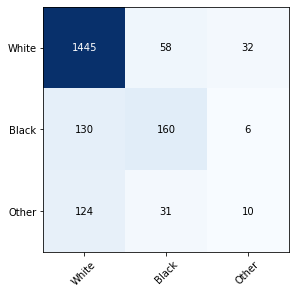

In [30]:
#  简单测试

#  创建待评价模型
model_test = resnet18(NUM_CLASSES)
model_test.to(DEVICE)

#  加载模型参数
model_test_path = './save/res_high/80.912.pt'
model_test.load_state_dict(torch.load(model_test_path, map_location = DEVICE))

#  预测模式
model_test.eval()

#  测试
labels = []
preds = []
with torch.no_grad():
    for idx, (features, targets) in enumerate(test_high_loader):

        features = features.to(DEVICE)

        _, pred = model_test(features)
        pred = torch.max(pred, dim = 1)[1]
        
        labels += targets.cpu().detach().numpy().tolist()
        preds += pred.cpu().detach().numpy().tolist()
        
ma_f1 = f1_score(labels, preds, average='macro')
mi_f1 = f1_score(labels, preds, average='micro')
print(ma_f1, mi_f1)

label_test = ['White', 'Black', 'Other']
draw_confusion_matrix(test_high_loader, model_test, label_test, NUM_CLASSES, DEVICE)

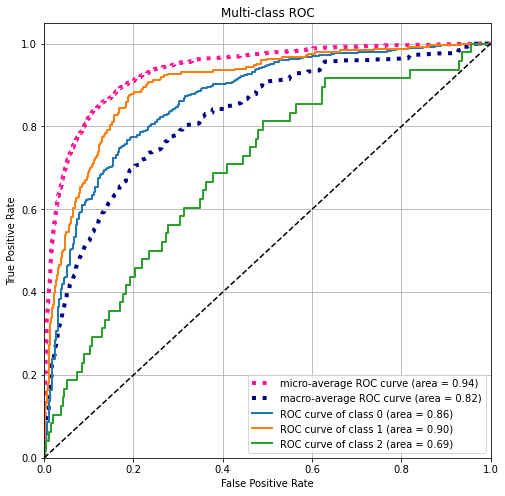

In [43]:
#  简单测试  --  ROC及AUC

scores = []
with torch.no_grad():
    for idx, (features, targets) in enumerate(test_high_loader):
        
        features = features.to(DEVICE)
        _, pred = model_test(features)
        
        scores += pred.cpu().detach().numpy().tolist()

scores = np.array(scores)
binary_label = label_binarize(labels, classes = list(range(NUM_CLASSES)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= NUM_CLASSES
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


In [75]:
## 各个模型性能指标

#  加载各个模型的参数


#  resnet
model_res_high = resnet18(NUM_CLASSES).to(DEVICE)
model_res_low = resnet18(NUM_CLASSES).to(DEVICE)

model_res_high_path = './save/res_high/80.912.pt'
model_res_high.load_state_dict(torch.load(model_res_high_path, map_location = DEVICE))
model_res_low_path = './save/res_low/64.583.pt'
model_res_low.load_state_dict(torch.load(model_res_low_path, map_location = DEVICE))


# densenet
model_den_high = DenseNet121(num_classes=NUM_CLASSES).to(DEVICE)
model_den_low = DenseNet121(num_classes=NUM_CLASSES).to(DEVICE)

model_den_high_path = './save/den_high/182.933.pt'
model_den_high.load_state_dict(torch.load(model_den_high_path, map_location = DEVICE))
model_den_low_path = './save/den_low/171.368.pt'
model_den_low.load_state_dict(torch.load(model_den_low_path, map_location = DEVICE))


# ViT
model_vit_high = ViT_model(num_classes= NUM_CLASSES).to(DEVICE)
model_vit_low = ViT_model(num_classes= NUM_CLASSES).to(DEVICE)

model_vit_high_path = './ViT_model/weights/model-4_high_904.pth'
model_vit_high.load_state_dict(torch.load(model_vit_high_path, map_location= DEVICE))
model_vit_low_path = './ViT_model/weights/model-12_low_729.pth'
model_vit_low.load_state_dict(torch.load(model_vit_low_path, map_location= DEVICE))

<All keys matched successfully>

In [63]:
##  定义性能指标函数

def model_performance(model, data_loader, num_classes, device, kind):
    
    model.eval()

    #  两类F1指标
    labels = []
    preds = []
    scores = []
    with torch.no_grad():
        for idx, (features, targets) in enumerate(data_loader):

            features = features.to(DEVICE)

            if (model == model_vit_low) or (model == model_vit_high):
                pred = model(features)
            else:
                _, pred = model(features)
            score = pred
            pred = torch.max(pred, dim = 1)[1]

            scores += score.cpu().detach().numpy().tolist()
            labels += targets.cpu().detach().numpy().tolist()
            preds += pred.cpu().detach().numpy().tolist()

    ma_f1 = f1_score(labels, preds, average='macro')
    mi_f1 = f1_score(labels, preds, average='micro')
    print('The Macro-F1 is:', ma_f1)
    print('The Micro-F1 is:', mi_f1)
    
    # 混淆矩阵
    if kind == 'high':
        kind_labels = ['White', 'Black', 'Other']
    elif kind == 'low':
        kind_labels = ['Asian', 'Hispanic', 'Other']
    draw_confusion_matrix(data_loader, model, kind_labels, num_classes, device)
    
    # ROC & AUC
    scores = np.array(scores)
    binary_label = label_binarize(labels, classes = list(range(num_classes)))

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i in range(3):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    #plt.savefig('Multi-class ROC.jpg', bbox_inches='tight')
    plt.show()

In [61]:
vit_high_data_transforms = {
    "train": transforms.Compose([transforms.Resize([224,224]),
                                 transforms.RandomRotation(5),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(train_high_mean, train_high_std)]),
    "test": transforms.Compose([transforms.Resize([224,224]),
                               transforms.ToTensor(),
                               transforms.Normalize(train_high_mean, train_high_std)])}
vit_low_data_transforms = {
    "train": transforms.Compose([transforms.Resize([224,224]),
                                 transforms.RandomRotation(5),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(train_low_mean, train_low_std)]),
    "test": transforms.Compose([transforms.Resize([224,224]),
                               transforms.ToTensor(),
                               transforms.Normalize(train_low_mean, train_low_std)])}

test_vit_high_dataset = RaceDatasetsHigh(img_dir = os.path.join('facedata', 'test'),
                            transform=vit_high_data_transforms['test'])

test_vit_high_loader = DataLoader(dataset = test_vit_high_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

test_vit_low_dataset = RaceDatasetsLow(img_dir = os.path.join('facedata', 'threetest'),
                            transform= vit_low_data_transforms['test'])

test_vit_low_loader = DataLoader(dataset = test_vit_low_dataset,
                        batch_size = BATCH_SIZE_LOW,
                        shuffle = False)

The Macro-F1 is: 0.6231970754403456
The Micro-F1 is: 0.7291666666666665
混淆矩阵总元素个数：48,测试集总个数:48
[[26.  6.  1.]
 [ 0.  4.  3.]
 [ 0.  3.  5.]]


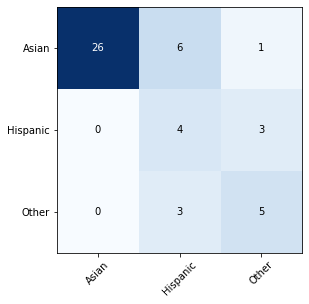

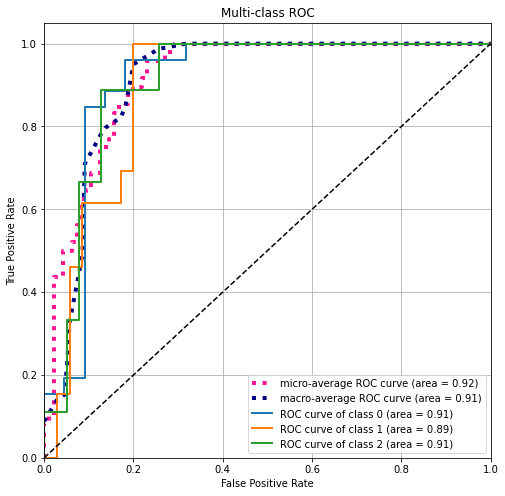

In [89]:
model_performance(model_vit_low, test_vit_low_loader, NUM_CLASSES, DEVICE, 'low')